In [1]:
import os
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
import arviz as az

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_beta_binomial"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'ds4p')

%config InlineBackend.figure_format = "retina"

In [3]:
df = pd.read_stata("../data/kidiq.dta")
df.head()

kid_score  mom_hs      mom_iq  mom_work  mom_age
0         65     1.0  121.117529         4       27
1         98     1.0   89.361882         4       25
2         85     1.0  115.443165         4       27
3         83     1.0   99.449639         3       25
4        115     1.0   92.745710         4       27

In [4]:
df.groupby(["mom_hs"]).size()

mom_hs
0.0     93
1.0    341
dtype: int64

In [5]:
df["kid_score"].mean()

86.79723502304148

In [6]:
summary_stats = [np.mean, stat.stdev]
df.groupby(["mom_hs"]).aggregate(summary_stats)

kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

In [7]:
89.319648 - 77.548387

11.771260999999996

In [8]:
# Vector of kid_score when mom_hs is 1
kid_score_mom_hs_1 = df[df["mom_hs"] == 1]["kid_score"]

# Vector of kid_score when mom_hs is 0
kid_score_mom_hs_0 = df[df["mom_hs"] == 0]["kid_score"]

In [9]:
stan_data = {
    'N1': len(kid_score_mom_hs_1), 
    'N2': len(kid_score_mom_hs_0), 
    'y1': kid_score_mom_hs_1,
    'y2': kid_score_mom_hs_0
}
stan_data

{'N1': 341,
 'N2': 93,
 'y1': 0       65
 1       98
 2       85
 3       83
 4      115
       ... 
 425    102
 426    104
 430     76
 432     88
 433     70
 Name: kid_score, Length: 341, dtype: int32,
 'y2': 5       98
 14     102
 19     101
 24      99
 33     106
       ... 
 422    100
 427     59
 428     93
 429     94
 431     50
 Name: kid_score, Length: 93, dtype: int32}

In [10]:
stan_file = os.path.join(project_directory, 'stan', 'kid-score.stan')
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=0> N1;  // number of observations (group 1)
  int<lower=0> N2;  // number of observations (group 2)
  vector[N1] y1;  // response times (group 1)
  vector[N2] y2;  // response times (group 2)
}

parameters {
  real mu_1;  // mean of group 1
  real mu_2;  // mean of group 2
  real<lower=0> sigma_1;  // standard deviation of group 1
  real<lower=0> sigma_2;  // standard deviation of group 2
}

transformed parameters {
  real delta;  // difference in means
  real cohen_d;  // Cohen's d effect size
  delta = mu_1 - mu_2;
  cohen_d = delta / sqrt((sigma_1^2 + sigma_2^2) / 2);
}

model {
  // Priors
  mu_1 ~ normal(80, 20);  // Prior for mean of group 1
  mu_2 ~ normal(80, 20);  // Prior for mean of group 2
  sigma_1 ~ normal(0, 10);  // Prior for standard deviation of group 1
  sigma_2 ~ normal(0, 10);  // Prior for standard deviation of group 2

  // Likelihood
  y1 ~ normal(mu_1, sigma_1);
  y2 ~ normal(mu_2, sigma_2);
}

generated quantities {
  vector[N1] y1_rep;  // 

In [11]:
sample = model.sample(
    data=stan_data, seed=123, chains=4,
    iter_sampling=1000, iter_warmup=1000,
    show_progress=False, show_console=False
)

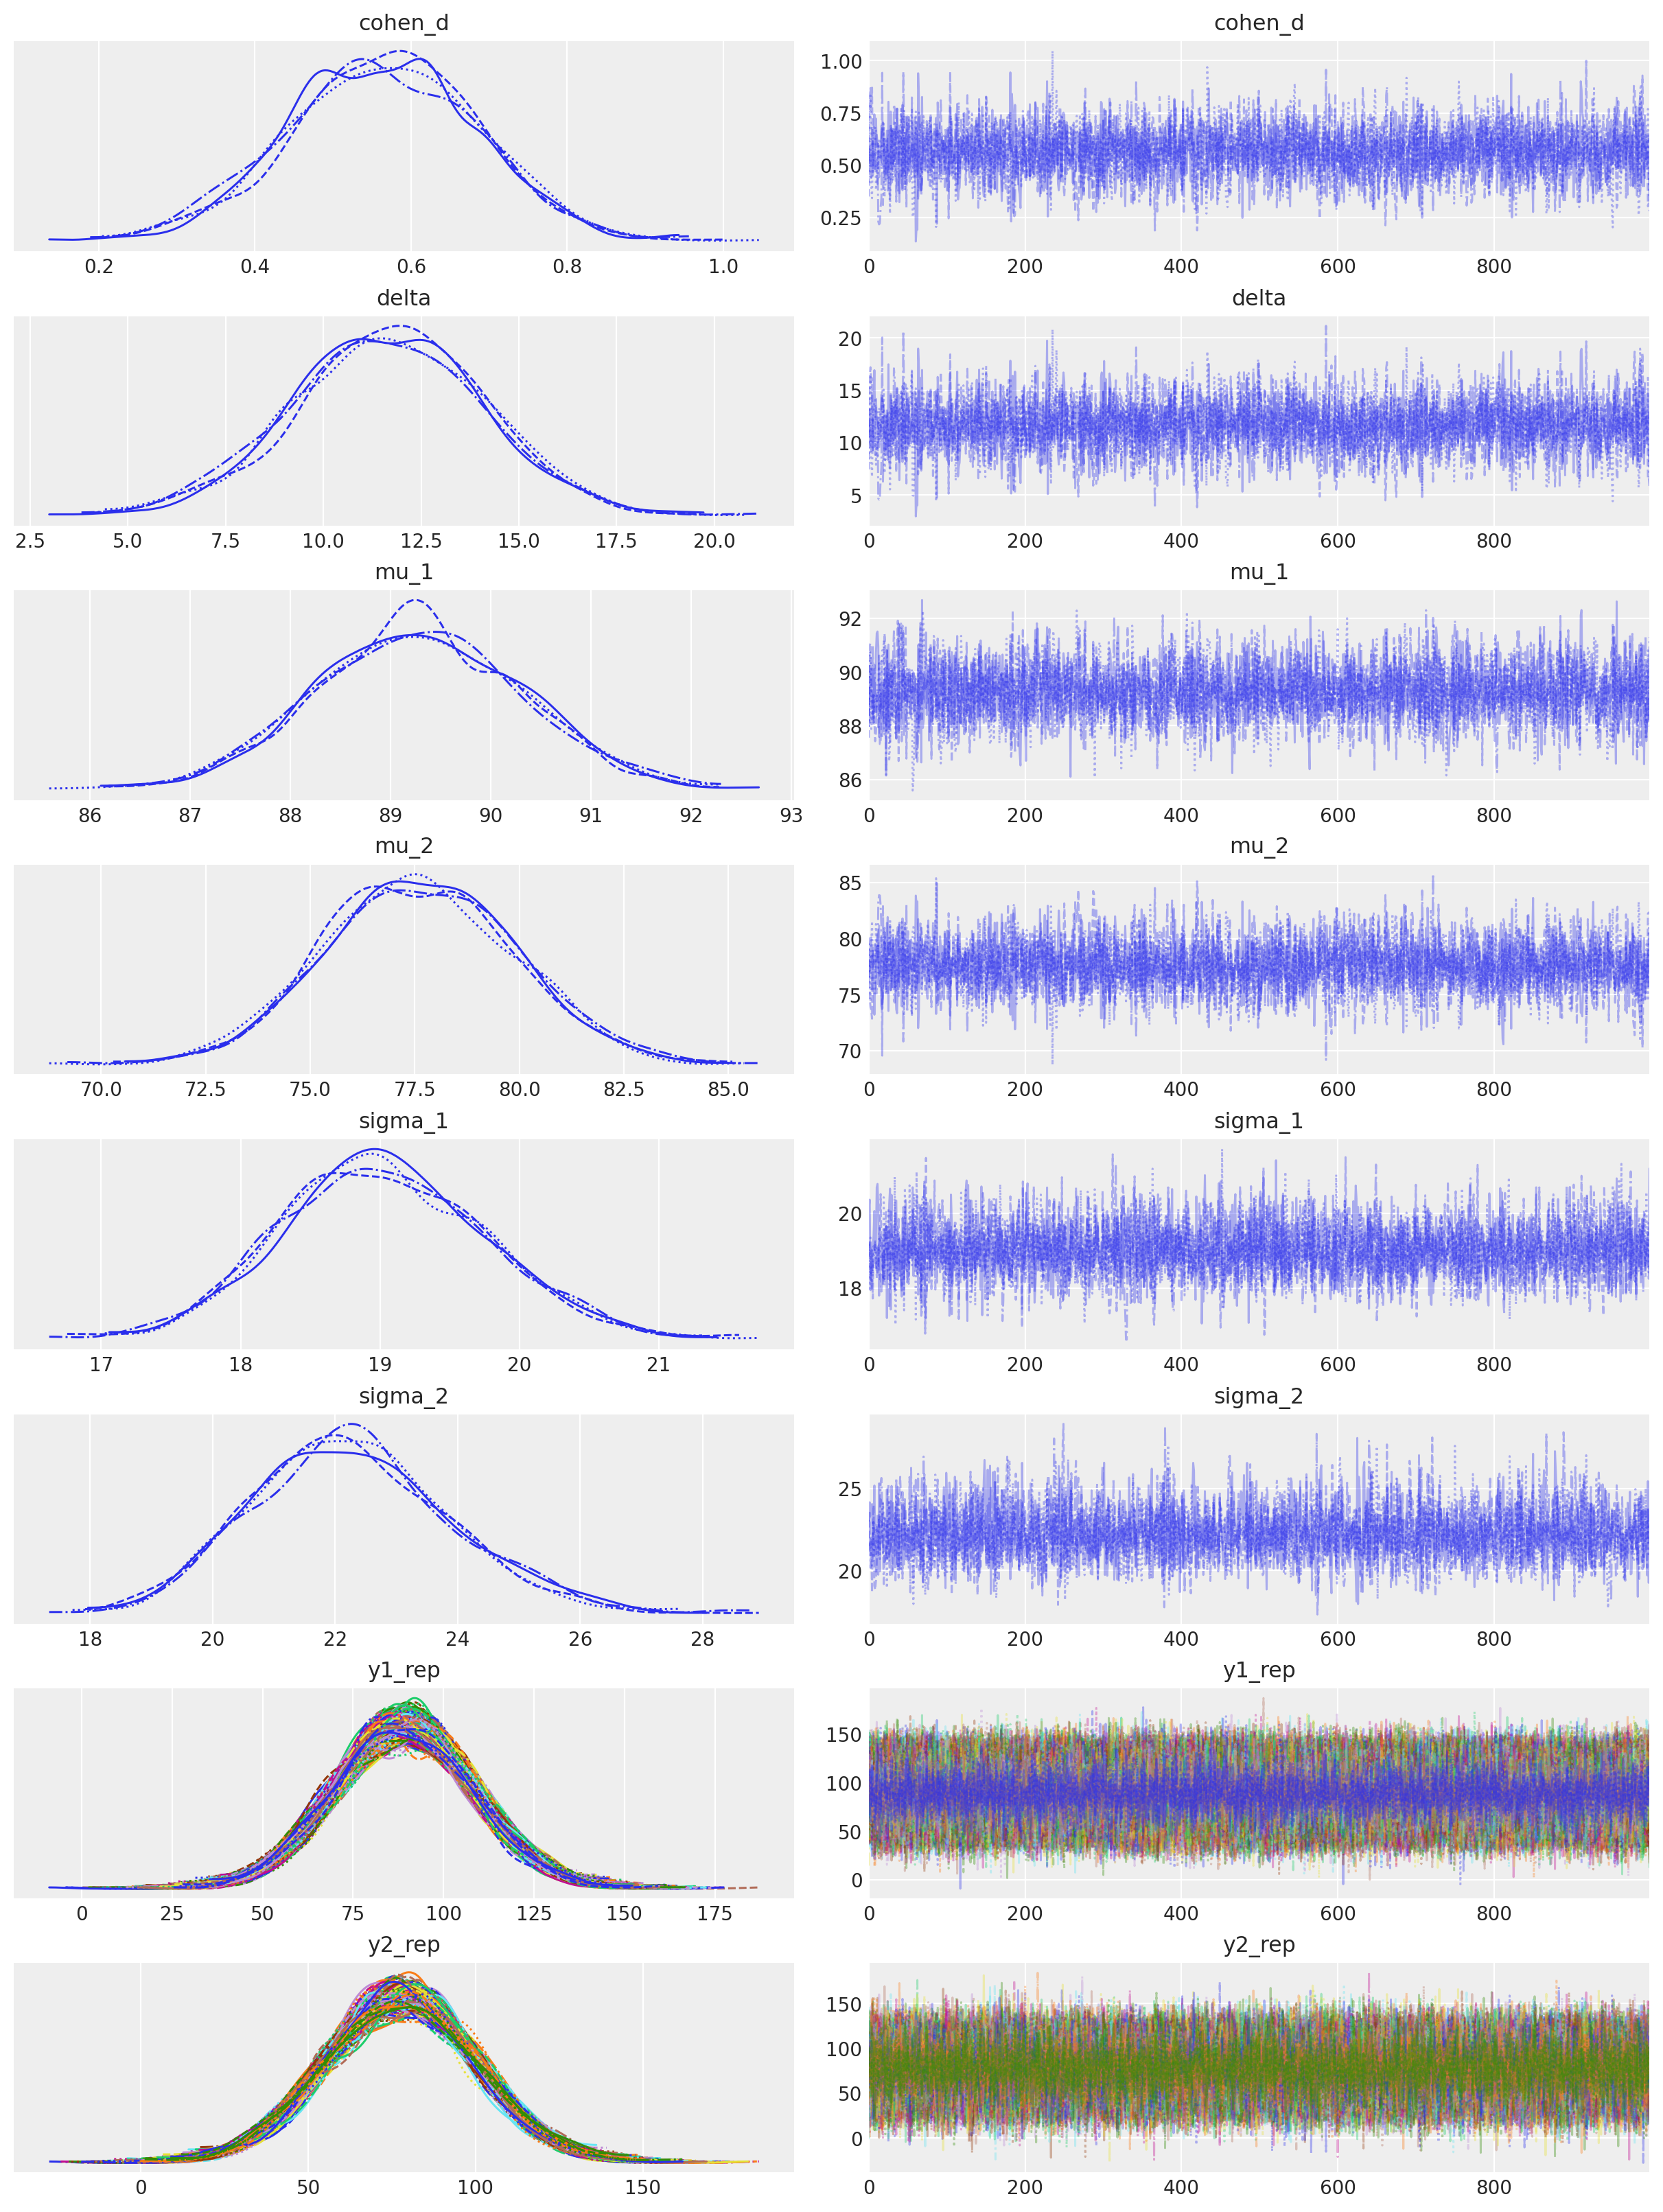

In [12]:
_ = az.plot_trace(sample, divergences="bottom")

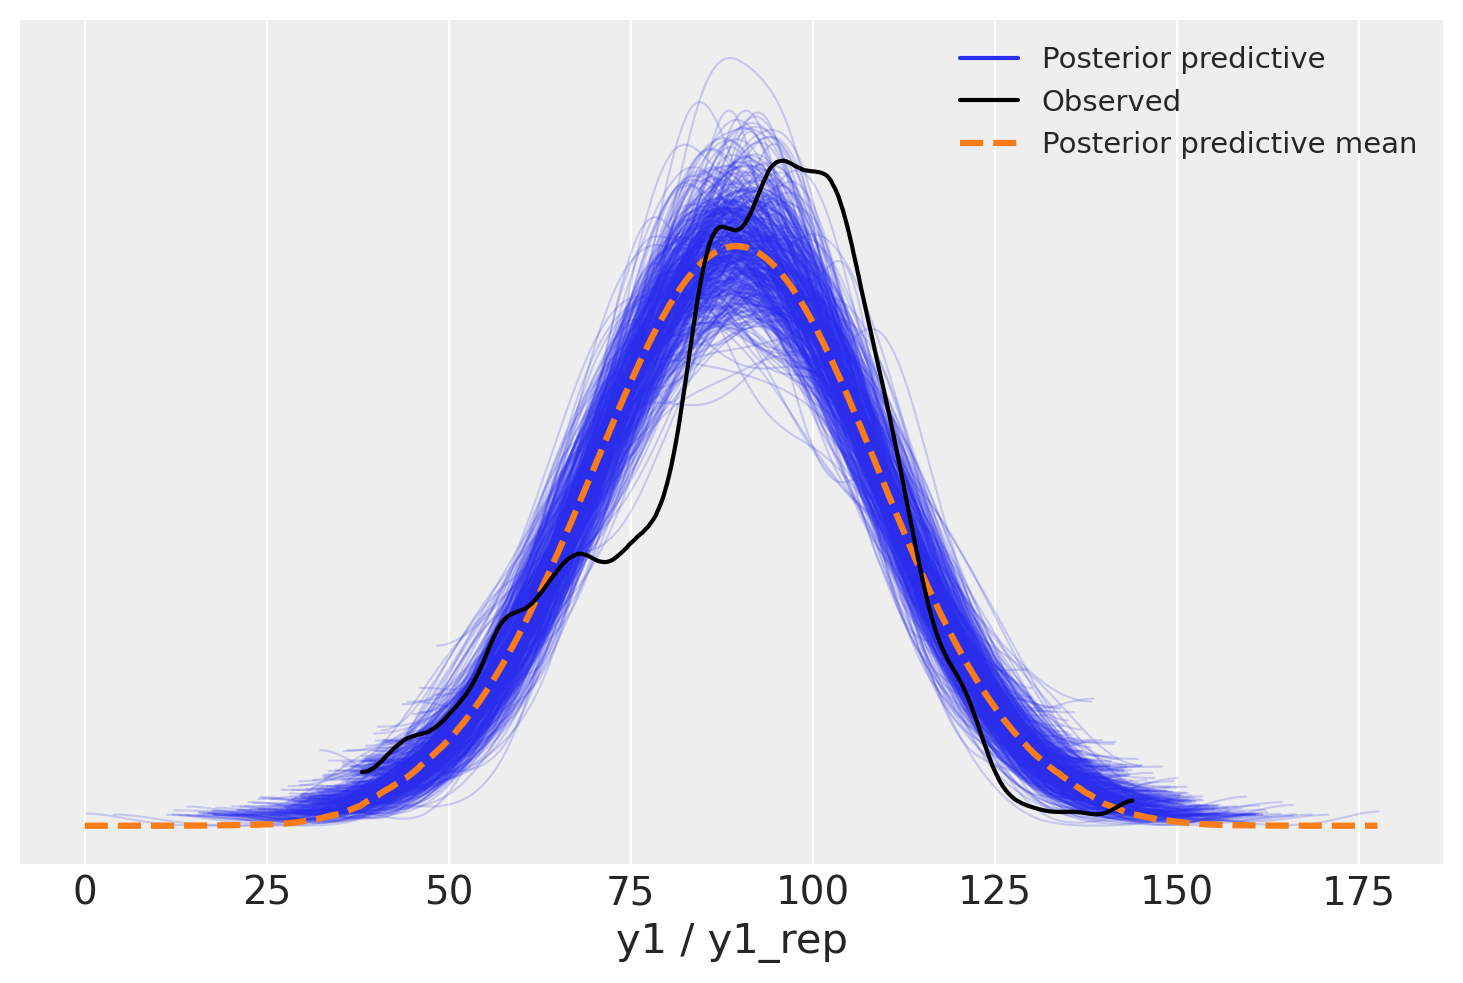

In [13]:
idata = az.from_cmdstanpy(
    posterior=sample, 
    posterior_predictive=['y1_rep'], 
    observed_data={"y1": stan_data["y1"]}
)
_ = az.plot_ppc(idata, data_pairs={"y1": "y1_rep"}, num_pp_samples=500)

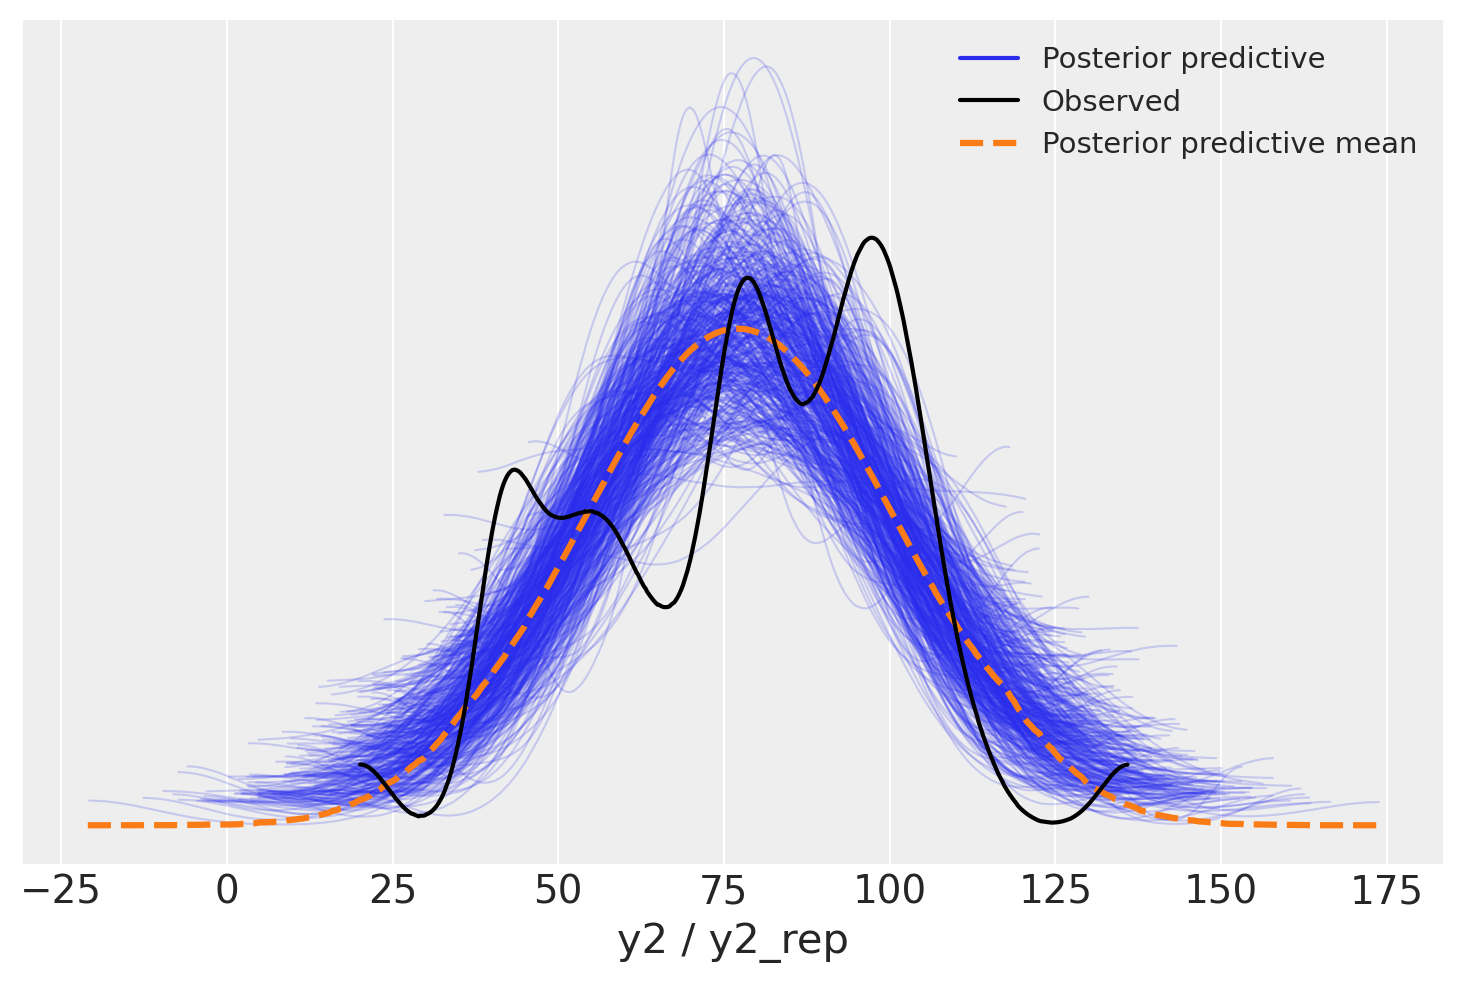

In [14]:
idata = az.from_cmdstanpy(
    posterior=sample, 
    posterior_predictive=['y2_rep'], 
    observed_data={"y2": stan_data["y2"]}
)
_ = az.plot_ppc(idata, data_pairs={"y2": "y2_rep"}, num_pp_samples=500)

In [15]:
az.summary(
    sample, 
    var_names=['mu_1', 'mu_2', 'sigma_1', 'sigma_2', 'delta', 'cohen_d'], 
    round_to=2
)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_1     89.28  1.04   87.33    91.18       0.02     0.01   3990.38   2947.67   
mu_2     77.61  2.27   73.61    82.01       0.03     0.02   4317.58   2940.56   
sigma_1  19.03  0.73   17.70    20.42       0.01     0.01   4729.21   3162.76   
sigma_2  22.27  1.63   19.35    25.38       0.02     0.02   4419.97   2908.53   
delta    11.67  2.47    6.89    16.32       0.04     0.03   4346.03   2887.27   
cohen_d   0.56  0.12    0.33     0.78       0.00     0.00   4334.34   2953.62   

         r_hat  
mu_1       1.0  
mu_2       1.0  
sigma_1    1.0  
sigma_2    1.0  
delta      1.0  
cohen_d    1.0

In [16]:
stan_file_t = os.path.join(project_directory, 'stan', 'kid-score-t.stan')
model_t = CmdStanModel(stan_file=stan_file_t)
print(model_t.code())

data {
  int<lower=0> N1;  // number of observations (group 1)
  int<lower=0> N2;  // number of observations (group 2)
  vector[N1] y1;  // response time (group 1)
  vector[N2] y2;  // response time (group 2)
}
parameters {
  real mu_2;  // mean of group 2
  real delta;  // difference in means
  real<lower=0> sigma_1;  // scale parameter for group 1
  real<lower=0> sigma_2;  // scale parameter for group 2
  real<lower=1> nu;  // degrees of freedom of student's t distribution
}
transformed parameters {
  real mu_1 = mu_2 + delta; 
}
model {
  y1 ~ student_t(nu, mu_1, sigma_1);
  y2 ~ student_t(nu, mu_2, sigma_2);
  // priors
  mu_2 ~ normal(80, 20);
  delta ~ normal(0, 10);
  sigma_1 ~ normal(0, 10);
  sigma_2 ~ normal(0, 10);
  nu ~ gamma(2, 0.1);
}
generated quantities {
  vector[N1] y1rep;
  vector[N2] y2rep;
  real pooled_sd = sqrt((sigma_1^2 + sigma_2^2) / 2);
  real cohen_d = delta / pooled_sd;
  
  for (i in 1:N1) {
    y1rep[i] = student_t_rng(nu, mu_1, sigma_1);
  }
  for (i in

In [17]:
sample_t = model_t.sample(
    data=stan_data, seed=123, chains=4,
    iter_sampling=1000, iter_warmup=1000,
    show_progress=False, show_console=False
)

In [18]:
az.summary(
    sample_t, 
    var_names=['mu_1', 'mu_2', 'sigma_1', 'sigma_2', 'delta', 'cohen_d'], 
    round_to=2
)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_1     89.49  1.07   87.43    91.37       0.02     0.01   3892.59   3003.83   
mu_2     78.39  2.29   74.04    82.63       0.05     0.03   2486.44   2273.07   
sigma_1  18.43  0.77   17.04    19.94       0.01     0.01   3278.45   2545.50   
sigma_2  21.71  1.62   18.77    24.82       0.03     0.02   3175.33   2299.83   
delta    11.11  2.50    6.40    15.82       0.05     0.04   2487.74   2084.50   
cohen_d   0.55  0.13    0.33     0.81       0.00     0.00   2496.90   2123.93   

         r_hat  
mu_1       1.0  
mu_2       1.0  
sigma_1    1.0  
sigma_2    1.0  
delta      1.0  
cohen_d    1.0

In [19]:
stan_file_h = os.path.join(project_directory, 'stan', 'kid-score-h.stan')
model_h = CmdStanModel(stan_file=stan_file_h)
print(model_t.code())

data {
  int<lower=0> N1;  // number of observations (group 1)
  int<lower=0> N2;  // number of observations (group 2)
  vector[N1] y1;  // response time (group 1)
  vector[N2] y2;  // response time (group 2)
}
parameters {
  real mu_2;  // mean of group 2
  real delta;  // difference in means
  real<lower=0> sigma_1;  // scale parameter for group 1
  real<lower=0> sigma_2;  // scale parameter for group 2
  real<lower=1> nu;  // degrees of freedom of student's t distribution
}
transformed parameters {
  real mu_1 = mu_2 + delta; 
}
model {
  y1 ~ student_t(nu, mu_1, sigma_1);
  y2 ~ student_t(nu, mu_2, sigma_2);
  // priors
  mu_2 ~ normal(80, 20);
  delta ~ normal(0, 10);
  sigma_1 ~ normal(0, 10);
  sigma_2 ~ normal(0, 10);
  nu ~ gamma(2, 0.1);
}
generated quantities {
  vector[N1] y1rep;
  vector[N2] y2rep;
  real pooled_sd = sqrt((sigma_1^2 + sigma_2^2) / 2);
  real cohen_d = delta / pooled_sd;
  
  for (i in 1:N1) {
    y1rep[i] = student_t_rng(nu, mu_1, sigma_1);
  }
  for (i in

In [20]:
sample_h = model_h.sample(
    data=stan_data, seed=123, chains=4,
    iter_sampling=2_000, iter_warmup=1_000,
    show_progress=False, show_console=False
)

In [21]:
az.summary(
    sample_h, 
    var_names=['mu_1', 'mu_2', 'sigma_1', 'sigma_2', 'delta', 'cohen_d'], 
    round_to=2
)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_1     89.52  1.03   87.65    91.54       0.01     0.01   8653.78   6400.92   
mu_2     78.30  2.29   73.95    82.52       0.03     0.02   5688.16   5777.55   
sigma_1  18.43  0.79   16.97    19.94       0.01     0.01   7954.84   5392.71   
sigma_2  21.88  1.65   18.88    25.08       0.02     0.01   9745.94   5250.42   
delta    11.22  2.50    6.51    15.83       0.03     0.02   5590.51   6029.02   
cohen_d   0.56  0.13    0.32     0.79       0.00     0.00   5626.06   5815.05   

         r_hat  
mu_1       1.0  
mu_2       1.0  
sigma_1    1.0  
sigma_2    1.0  
delta      1.0  
cohen_d    1.0

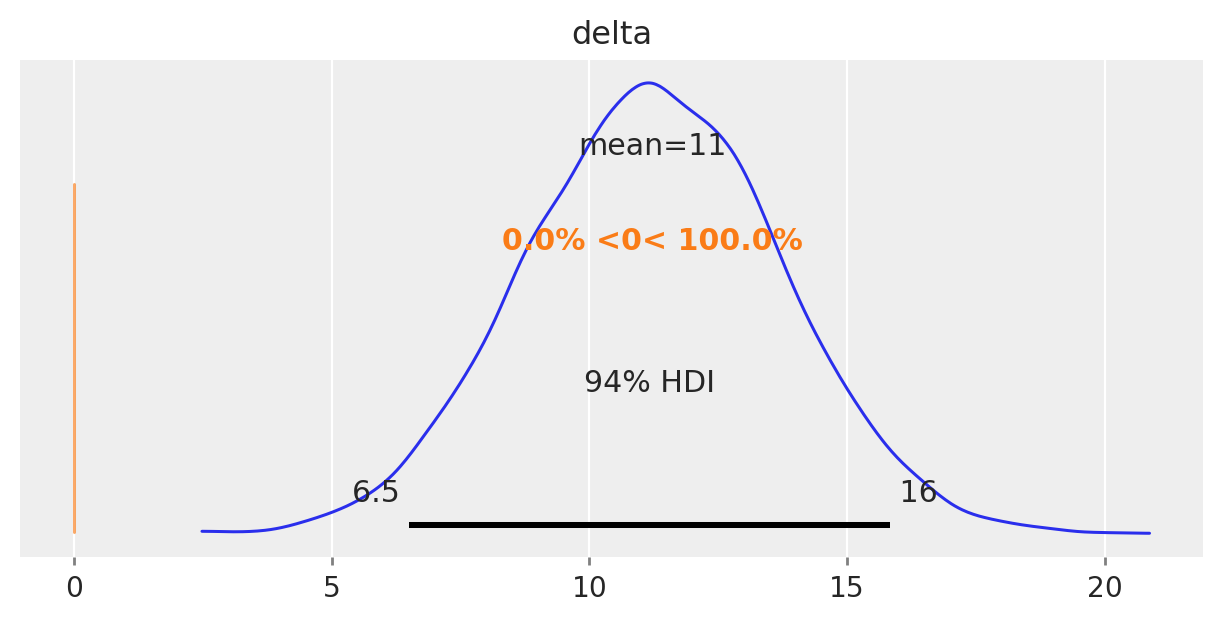

In [22]:
_ = az.plot_posterior(sample_h, var_names="delta", ref_val=0, figsize=(6, 3))

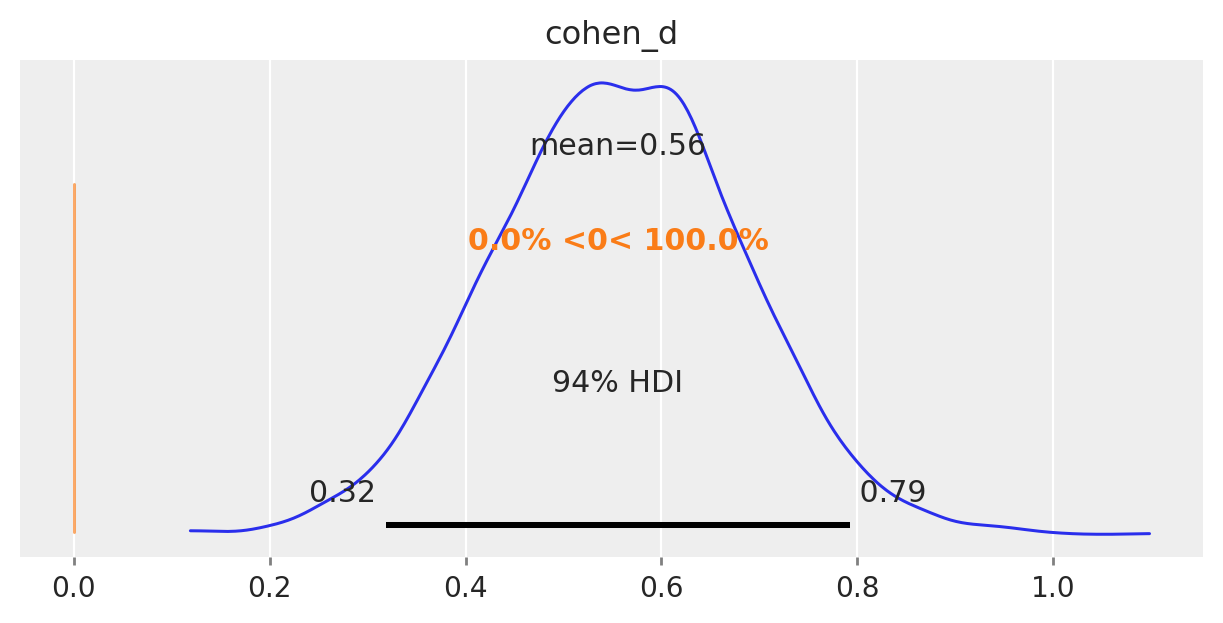

In [23]:
_ = az.plot_posterior(sample_h, var_names="cohen_d", ref_val=0, figsize=(6, 3))

In [24]:
# Extract the posterior samples for mu_1 and mu_2
posterior = sample_h.draws_pd()
posterior['mu_1'] = posterior['mu_2'] + posterior['delta']

# Compute the probability that mu_1 > mu_2
prob_mu1_greater_mu2 = np.mean(posterior['mu_1'] > posterior['mu_2'])

print(f"Probability that mu_1 > mu_2: {prob_mu1_greater_mu2:.4f}")

Probability that mu_1 > mu_2: 1.0000


In [25]:
%load_ext watermark
%watermark -n -u -v -iv -w -m 

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

cmdstanpy : 1.2.3
logging   : 0.5.1.2
matplotlib: 3.8.4
arviz     : 0.18.0
pandas    : 2.2.2
numpy     : 1.26.4

Watermark: 2.4.3

